## Active Contours using Level Sets

In [93]:
from __future__ import division

import scipy as scp
import numpy as np
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Managing level set functions

Dans la partie "Active Contours using parametric curves", nous avons représenté une courbe comme : $f(p) : S^1 \rightarrow \mathbb{R}^2$, une courbe dépendant d'un paramètre $p$. Pour chacun des $p$, nous avions un point de la courbe.

Désormais, nous allons représenter une courbe de façon implicite. Ce sont tous les points, c'est à dire tous les plans, satisfaisant une certaine équation égale à 0.
$$ \gamma = \{(x,y) | \phi(x,y) = 0\} $$

Une courbe fermée définit une forme. La courbe correspondant aux points où $\phi(x,y) = 0$, nous aurons alors $\phi < 0$ à l'extérieur et $\phi > 0$ à l'intérieur par exemple.

In [94]:
#discrétisation de taille nxn du domaine [0,1]²
n = 200
Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))

On pose $\varphi_{1}$ la fonction qui à x associe la distance entre x et le cercle de centre c et de rayon r.

In [95]:
r = n/3. #rayon du cercle

In [96]:
c = np.array([r,r]) + 10 #centre du cercle

In [97]:
phi1 = np.sqrt((X-c[0])**2 + (Y-c[1])**2) - r

#### Exercise 1 Load a square shape $\varphi_{2}$ at a different position for the center.

On fait de même pour un carré.

In [98]:
#nouvelle position du centre
c = - np.array([r,r]) - 10 + n 

#pour avoir un carré : on fonctionne avec les valeurs absolues
A = abs(X-c[0]) 
B = abs(Y-c[1])
phi2 = np.maximum(A,B) - r

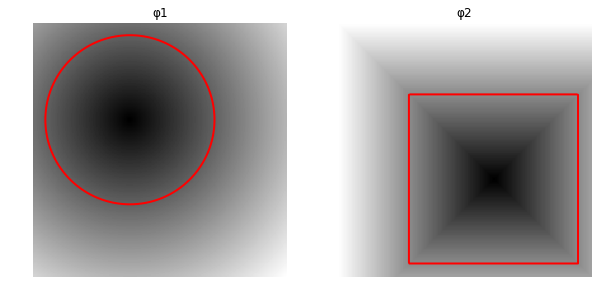

In [99]:
from nt_toolbox.plot_levelset import *
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.title("φ1")
plot_levelset(phi1)

plt.subplot(1,2,2)
plt.title("φ2")
plot_levelset(phi2)

#### Exercise 2 : Compute the intersection and the union of the two shapes. Store the union in $\varphi_{0}$ that we will use in the remaining part of the tour.

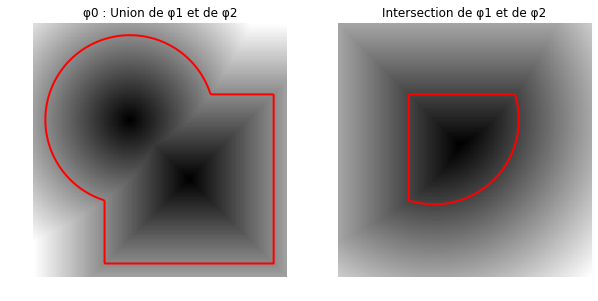

In [100]:
plt.clf
plt.figure(figsize = (10,5))

#définition de phi0 par l'union, ie: le minimum
phi0 = np.minimum(phi1,phi2)

#union, ie : min
plt.subplot(1,2,1)
plt.title("φ0 : Union de φ1 et de φ2")
plot_levelset(phi0)

#intersection, ie : max
plt.subplot(1,2,2)
plt.title("Intersection de φ1 et de φ2")
plot_levelset(np.maximum(phi1,phi2))

### Mean Curvature Motion

On pose $\varphi_{t}$ une famille de courbes de niveaux paramétrées par un temps artificiel t, qui satisfait l'EDP suivante, aussi appelée équation du Mean Curvature Motion :

$$ \frac{\partial\varphi_{t}}{\partial t}=-G(\varphi_{t}) $$ avec $$ G(\varphi)=-\|\nabla\varphi\| div\left(\frac{\nabla\varphi}{\|\nabla\varphi\|}\right) $$


L'idée est de déterminer $\varphi$ par une descente de gradient :
$$ \varphi^{(l+1)}=\varphi^{(l)}-\tau G(\varphi^{(l)}) $$

In [101]:
#Temps max pour l'évolution
Tmax = 200 
#intervalle de temps
tau = .5 
#nombre maximal d'itérations
niter = int(Tmax/tau) 

In [102]:
#initialisation de φ à l'instant 0 de la descente de gradient
phi = np.copy(phi0) 

Tous les éléments de l'équation précédente ont besoin d'être déterminés. Pour commencer, on calcule le gradient $\nabla\varphi$ en utilisant la méthode des différences finies :

In [103]:
from nt_toolbox.grad import *
#calcul du gradient
#order = 2 : utilisation du schéma centré
g0 = grad(phi, order=2) 

On passe au calcul de la norme du gradient $\|\nabla\varphi\|$ :

In [104]:
#donne le plus petit float tel que 1. + eps soit différent de 1.
eps = np.finfo(float).eps 
#norme du gradient
norm = np.sqrt(np.sum(g0**2, 2))
#max entre un float très très petit et la norme du gradient : pour qu'il n'y ait pas d'éléments nuls dans d
d = np.maximum(eps*np.ones([n,n]),norm) 

On calcule le gradient normalisé :

In [105]:
g = g0/np.repeat(d[:,:,np.newaxis], 2, 2)

Puis le terme de courbure $G$ :

In [106]:
from nt_toolbox.div import *
G = -1 * d * div(g[:,:,0], g[:,:,1], order=2)

On peut à présent effectuer la première étape de la descente du gradient :

In [107]:
phi = phi - tau*G

#### Exercise 3 Implement the mean curvature motion.

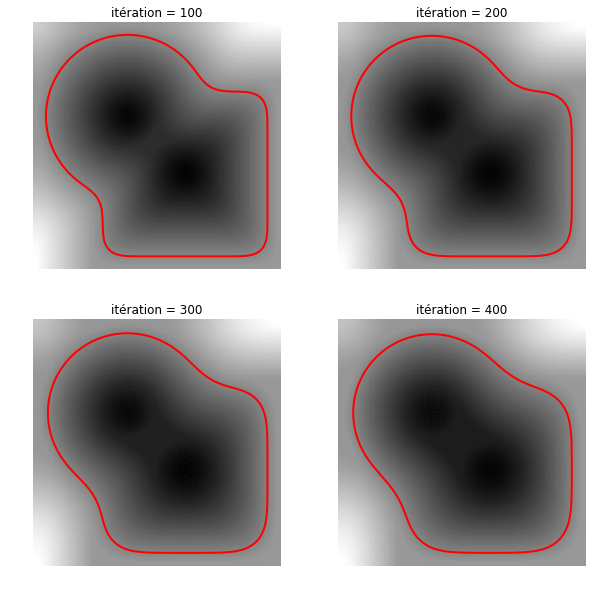

In [109]:
#pour avoir 4 sous-figures, on sépare les itérations en 4 sous-ensembles.
aff = np.arange(int(niter/4.),niter+1,int(niter/4.))

#initialisation
phi = np.copy(phi0)

plt.figure(figsize = (10,10))

k = 0
#algorithme du mean curvature motion tel que décrit précédemment
for i in range(1,niter+1):
    g0 = grad(phi, order=2)
    d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(g0**2, 2)))
    g = g0/np.repeat(d[:,:,np.newaxis], 2, 2)
    G = -1 * d * div(g[:,:,0], g[:,:,1], order=2)
    phi = phi - tau*G
    if i==aff[k]:
        #affichage de l'évolution de l'algorithme
        k = k+1 
        plt.subplot(2,2,k)
        plt.title("itération : "+str(i))
        plot_levelset(phi)


### Levelset Re-distancing

In [110]:
phi = phi0**3

In [111]:
from nt_toolbox.perform_redistancing import *
phi1 = perform_redistancing(phi0)

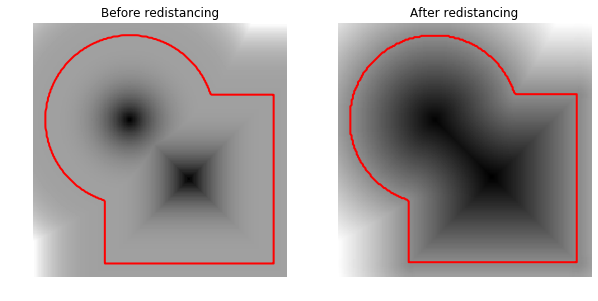

In [112]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plot_levelset(phi)
plt.title("Before redistancing")

plt.subplot(1,2,2)
plot_levelset(phi1)
plt.title("After redistancing")

plt.show()

# Pas de changement, bizarre non ? 

### Edge-based Segmentation with Geodesic Active Contour

Taille $n$ de l'image et téléchargement de l'image.

In [121]:
n = 200
f0 = rescale(load_image("nt_toolbox/data/cortex.bmp", n))

Calcul du gradient et sa magnitude.

In [114]:
g = grad(f0, order=2) #calcul du gradient
d0 = np.sqrt(np.sum(g**2, 2)) #magnitude

In [115]:
a = 5 #coefficient de floutage

In [116]:
from nt_toolbox.perform_blurring import *
d = perform_blurring(d0, np.asarray([a]),bound="per") #floutage

[200 200]


TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
epsilon = 1e-1

In [ ]:
W = 1./(epsilon + d)
W = rescale(-d, 0.1, 1) #redimensionnement

In [ ]:
plt.figure(figsize=(10,5))
imageplot(f0, "Image to segment", [1,2,1])
imageplot(W, "Weight", [1,2,2])

#### Exercise 4 Compute an initial shape φ0 at time t=0, for instance a centered square.

On reprend les données du début de fichier puis on initialise la forme φ0.

In [ ]:
#Données exo 1
Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))
r = n/3
c = np.array([r,r])/2 + r

#Forme initiale
phi0 = np.maximum(abs(X-c[0]),abs(Y-c[1])) - r

Affichage.

In [ ]:
plt.figure(figsize=(5,5))
plot_levelset(phi0, 0, f0)

In [ ]:
tau = .4 #pas
Tmax = 1500 #temps max
niter = int(Tmax/tau) #nombre d'itérations
phi = np.copy(phi0) #copie de phi0 dans phi

In [ ]:
gW = grad(W, order=2) #gradient de W, ordre 2

#### Exercise 5 Compute and store in G the gradient G(φ)(right hand side of the PDE) using the current value of the distance function φ.

In [ ]:
gD = grad(phi, order=2)
d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(g0**2, 2)))
#Normalisation
g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)

#Gradient
G = W * d * div(g[:,:,0], g[:,:,1], order=2) - sum(gW*gD,3)


In [ ]:
phi = phi + tau*G

In [ ]:
phi = perform_redistancing(phi)

#### Exercise 6 Implement the geodesic active contours gradient descent. Do not forget to do the re-distancing.


In [ ]:
#Initialisation évolution
phi = phi0

k = 0
gW = grad(W,order=2)
for i in range(1,niter):
    gD = grad(phi,order=2)
    d = np.maximum(eps, sqrt(sum(gD^2,3)))
    g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)
    G = W * d * div(g,order=2) + sum(gW*gD,3)
    phi = phi + tau*G
    if i%30==0 :
        phi = perform_redistancing(phi)
    if i%floor(niter/4)==0 :
        k = k+1
        subplot(2,2,k)
        plot_levelset(phi,0,f0)

### Region-based Segmentation with Chan-Vese

#### Exercise 7 Compute an initial level set function φ0, stored in phi0, for instance many small circles.

In [ ]:
Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))
k = 4
r = .3*n/k #rayon
phi0 = zeros(n,n) + math.inf
for i in range(1,k):
    for j in range(1,k):
        c = ([i j]- np.ones[1,2])*(n/k) + (n/k)*.5
        phi0 = np.minimum(phi0, sqrt( (X-c(1))^2 + (Y-c(2))^2 ) - r )

plt.clf
plt.subplot(1,2,1)
plot_levelset(phi0)
plt.subplot(1,2,2)
plot_levelset(phi0,0,f0)

In [ ]:
lambd = 2
c1 = .7
c2 = 0
tau = .5
Tmax = 100
niter = int(Tmax/ tau)

In [ ]:
phi = np.copy(phi0)

#### Exercise 8 Compute this gradient G(φ) using the current value of the distance function.

In [ ]:
gD = grad(phi,order = 2)
d = np.maximum(eps, sqrt(sum(gD.^2,3)))
g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)
#gradient
G = d * div( g,order=2) - lambd*(f0-c1)^2 + lambd*(f0-c2)^2;

In [ ]:
phi = phi + tau*G

#### Exercise 9 Implement the full gradient descent.


In [ ]:
#intialisation
phi = phi0

k = 0
plt.clf
for i in range(1,niter+1):
    gD = grad(phi,order=2)
    d = max(eps, sqrt(sum(gD.^2,3)) )
    g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)
    G = d .* div( g,options ) - lambd*(f0-c1)^2 + lambd*(f0-c2)^2
    phi = phi + tau*G
    if i%30==0 :
        phi = perform_redistancing(phi)
    if i % floor(niter/4)==0 :
        k = k+1
        plt.ubplot(2,2,k)
        plot_levelset(phi,0,f0)